In [68]:
# Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [69]:
plots = gpd.read_file('/Users/michaldeja/Library/CloudStorage/OneDrive-Personal/Documents/Politechnika Gdańska/Magister/Dyplom/02_GIS/Poznan/moja_dzialka_na_egib.gpkg')
buildings = gpd.read_file('/Users/michaldeja/Library/CloudStorage/OneDrive-Personal/Documents/Politechnika Gdańska/Magister/Dyplom/02_GIS/Poznan/EGIB/EGIB_budynki_poznan_2177.gpkg')

In [70]:
plots 

,ID_DZIALKI,NAZWA_GMINY,NAZWA_OBREBU,NUMER_DZIALKI,NUMER_OBREBU,NUMER_ARKUSZA,POLE_EWIDENCYJNE,KW,GRUPA_REJESTROWA,OZNACZENIE_UZYTKU,OZNACZENIE_KONTURU,DATA,ID,MSGEOMETRY.AREA,MSGEOMETRY.LEN,geometry
0,306401_1.0020.AR_42.1/22,Poznań,GOLĘCIN,1/22,20.0,42,0.0395,None,4.1,dr,None,2025-01-29 02:35:07,23468.0,0.0,0.0,"MULTIPOLYGON (((6426473.3 5810380.36, 6426471...."
1,306401_1.0020.AR_31.153,Poznań,GOLĘCIN,153,20.0,31,0.0826,None,4.1,Ti,None,2025-01-29 02:35:07,24717.0,0.0,0.0,"MULTIPOLYGON (((6426434.46 5810398.27, 6426431..."
2,306401_1.0020.AR_42.1/9,Poznań,GOLĘCIN,1/9,20.0,42,0.0053,None,4.1,dr,None,2025-01-29 02:35:07,24779.0,0.0,0.0,"MULTIPOLYGON (((6426428.16 5810374.36, 6426427..."
3,306401_1.0020.AR_31.154/1,Poznań,GOLĘCIN,154/1,20.0,31,0.0662,None,4.1,Ti,None,2025-01-29 02:35:07,137975.0,0.0,0.0,"MULTIPOLYGON (((6426444.5 5810393.42, 6426447...."
4,306401_1.0020.AR_31.158,Poznań,GOLĘCIN,158,20.0,31,0.1067,None,4.1,Ti,None,2025-01-29 02:35:07,24618.0,0.0,0.0,"MULTIPOLYGON (((6426481.12 5810414.67, 6426473..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118628,306401_1.0024.AR_02.11/2,Poznań,PSARSKIE,11/2,24.0,02,0.0049,None,4.1,R,RVI,2025-01-29 02:35:07,691103.0,0.0,0.0,"MULTIPOLYGON (((6418643.09 5816587.93, 6418636..."
118629,306401_1.0024.AR_02.11/3,Poznań,PSARSKIE,11/3,24.0,02,0.0258,None,4.1,"R, Ł","RV, ŁVI",2025-01-29 02:35:07,691104.0,0.0,0.0,"MULTIPOLYGON (((6418734.32 5816588.22, 6418717..."
118630,306401_1.0024.AR_02.11/1,Poznań,PSARSKIE,11/1,24.0,02,0.1127,None,4.1,"R, Ł","RV, RVI, ŁV, ŁVI",2025-01-29 02:35:07,691105.0,0.0,0.0,"MULTIPOLYGON (((6418576.39 5816590.62, 6418578..."
118631,306401_1.0024.AR_02.11/4,Poznań,PSARSKIE,11/4,24.0,02,0.6125,None,4.1,"R, Ł","RV, RVI, ŁV, ŁVI",2025-01-29 02:35:07,691106.0,0.0,0.0,"MULTIPOLYGON (((6418778.26 5816612.23, 6418763..."


In [71]:
#site_id = '306401_1.0039.AR_10.20'
site_id = 'moja'
site = plots[plots['ID_DZIALKI'] == site_id]
site_polygon = site.geometry.iloc[0]

In [72]:

analysis_area = site.buffer(17.41*3)
#analyzed_plots = plots[plots.geometry.intersects(analysis_area.union_all())]
#print(analyzed_plots.shape[0], "plots in analysis area")

In [73]:
buildings['centroid'] = buildings.centroid
building_centroids = buildings.set_geometry('centroid', inplace=False).set_crs(epsg=2177)

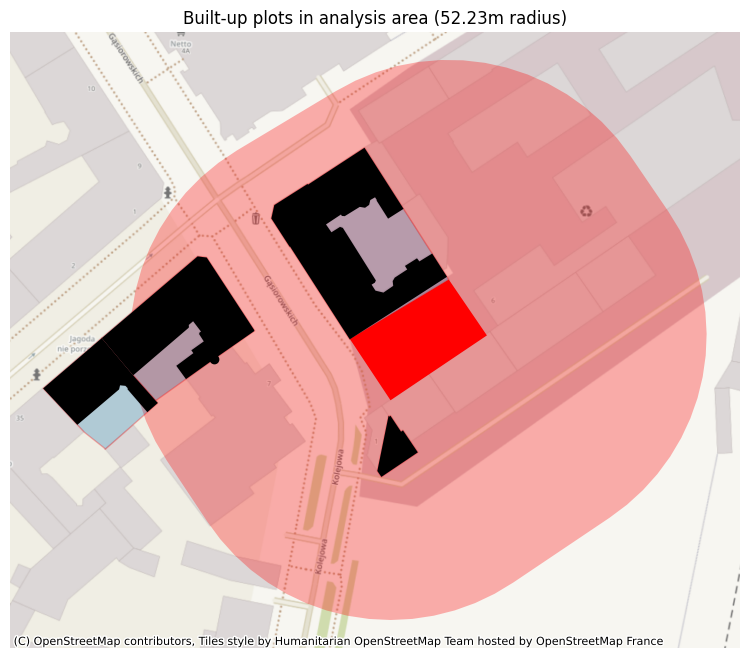

In [74]:
neighbors_ids = ['306401_1.0039.AR_10.22', '306401_1.0039.AR_10.47', '306401_1.0039.AR_10.48']
analyzed_plots = plots[plots['ID_DZIALKI'].isin(neighbors_ids)]
built_up_plots = gpd.sjoin(analyzed_plots, building_centroids, how='inner', predicate='intersects', lsuffix='plot', rsuffix='building')


# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', label='Site')
gpd.GeoSeries(analysis_area).plot(ax=ax, color='red', alpha=0.3, label='Analysis Area')
built_up_plots.drop_duplicates(subset='ID_DZIALKI').plot(ax=ax, edgecolor='red', alpha=0.3, label='Analysis Plots')
buildings.clip(built_up_plots.geometry.union_all()).plot(ax=ax, color='black', label='Buildings')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.title(f"Built-up plots in analysis area ({17.41*3:.2f}m radius)")
plt.show()


In [75]:
plot_road_sides = []
access_roads = []
front_elevations = []
plot_metrics = []

for _, plot in built_up_plots.iterrows():
    print("\nPlot", plot['ID_DZIALKI'])
    
    plot_area = plot.geometry.area
    print(f"Plot area: {plot_area:.0f} m2")

    plot_buildings = buildings[buildings['ID_BUDYNKU'].isin(
        built_up_plots[
            built_up_plots['ID_DZIALKI'] == plot['ID_DZIALKI']
        ]['ID_BUDYNKU']
    )]
    print("Plot buildings:", plot_buildings.shape[0])

    # Building coverage ratio
    bcr = plot_buildings.geometry.area.sum() / plot_area
    print("Building coverage ratio:", bcr)

    # Floor area ratio
    building_footprint = plot_buildings.geometry.area
    floors = plot_buildings['KONDYGNACJE']
    gross_floor_area = building_footprint * floors
    total_gross_floor_area = gross_floor_area.sum()
    far = total_gross_floor_area / plot_area
    print("Floor area ratio:", far)

    plot_metrics.append({
        'plot_id': plot['ID_DZIALKI'],
        'building_coverage_ratio': bcr,
        'floor_area_ratio': far
    })

# Convert to DataFrame for analysis
plot_metrics_df = pd.DataFrame(plot_metrics).drop_duplicates(subset='plot_id')
plot_metrics_df
    


Plot 306401_1.0039.AR_10.48
Plot area: 363 m2
Plot buildings: 1
Building coverage ratio: 0.6652474090271966
Floor area ratio: 3.326237045135983

Plot 306401_1.0039.AR_10.47
Plot area: 632 m2
Plot buildings: 1
Building coverage ratio: 0.8032652506965378
Floor area ratio: 4.0163262534826885

Plot 306401_1.0039.AR_10.21/1
Plot area: 68 m2
Plot buildings: 1
Building coverage ratio: 1.6737098857713393
Floor area ratio: 3.3474197715426786

Plot 306401_1.0039.AR_10.22
Plot area: 1012 m2
Plot buildings: 1
Building coverage ratio: 0.7337736236361808
Floor area ratio: 3.668868118180904


,plot_id,building_coverage_ratio,floor_area_ratio
0,306401_1.0039.AR_10.48,0.665247,3.326237
1,306401_1.0039.AR_10.47,0.803265,4.016326
2,306401_1.0039.AR_10.21/1,1.673710,3.347420
3,306401_1.0039.AR_10.22,0.733774,3.668868


In [76]:
# Zoning conditions coverage ratio from min to mean+20%
zoning_coverage_ratio_min = float(plot_metrics_df['building_coverage_ratio'].min())
zoning_coverage_ratio_max = float(plot_metrics_df['building_coverage_ratio'].mean() * 1.2)
zoning_floor_area_ratio = float(plot_metrics_df['floor_area_ratio'].mean() * 1.2)
#zoning_height = plot_metrics_df['building_height'].mean()
#zoning_front_width = float(plot_metrics_df['front_elevation_width'].mean() * 1.2)
#zoning_setback = float(plot_metrics_df['setback'].max())

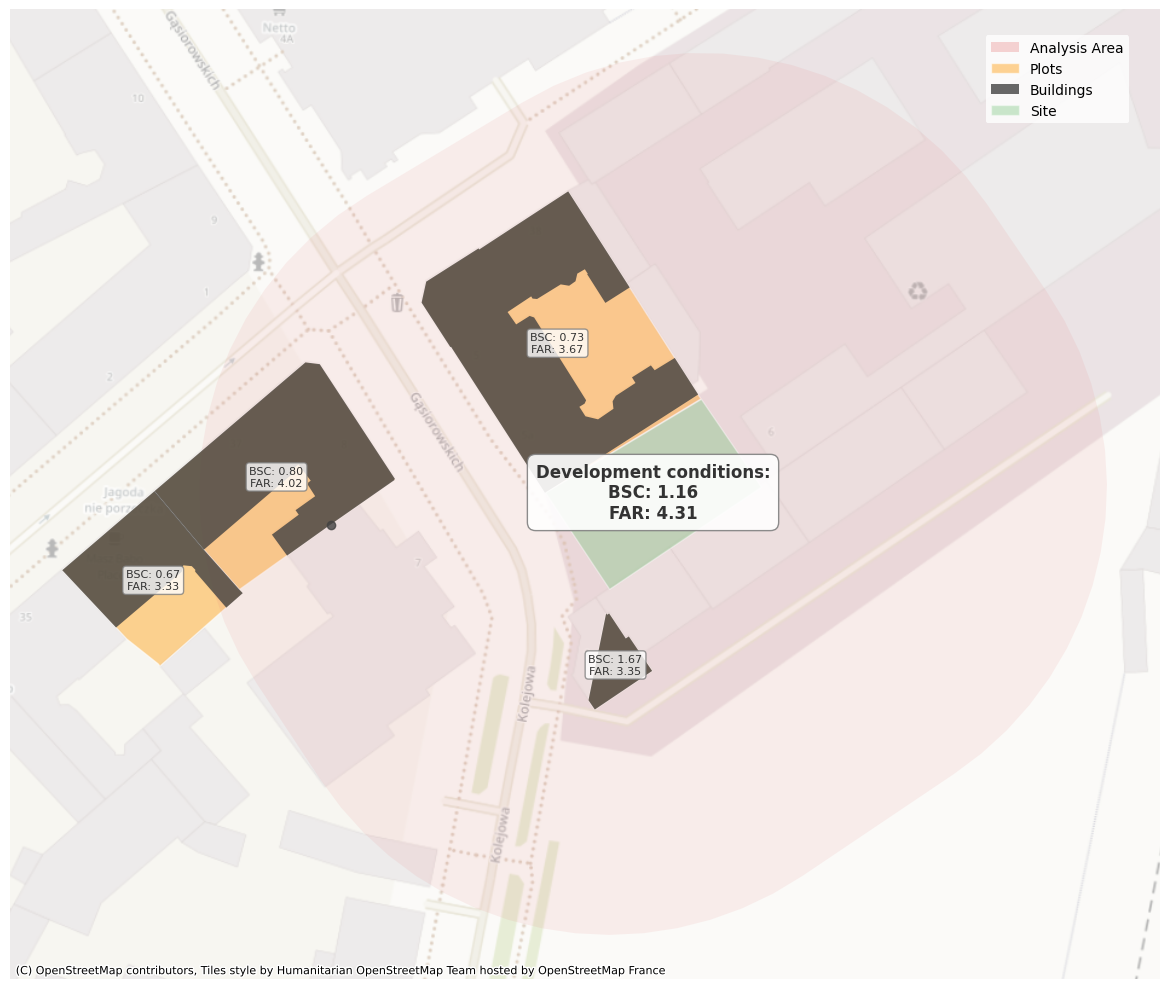

In [87]:
# Import required libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Visualize with enhanced styling
# Set up the figure with a clean white background
fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
ax.set_facecolor('white')

# Define a modern color palette
plot_color = '#FFB74D'  # Warm orange
road_color = '#E57373'  # Soft red
building_color = '#424242'  # Dark gray
site_color = '#81C784'  # Soft green

# Plot base layers with enhanced styling
built_up_plots.plot(ax=ax, color=plot_color, edgecolor='white', alpha=0.6, linewidth=1)
gpd.GeoSeries(analysis_area).plot(ax=ax, color=road_color, alpha=0.1, label='Analysis Area')
buildings.clip(built_up_plots.geometry.union_all()).plot(ax=ax, color=building_color, alpha=0.8)
site.plot(ax=ax, color=site_color, alpha=0.4, edgecolor='white', linewidth=1)

# Create custom legend elements
legend_elements = [
    Patch(facecolor=road_color, alpha=0.3, label='Analysis Area'),
    Patch(facecolor=plot_color, edgecolor='white', alpha=0.6, label='Plots'),
    Patch(facecolor=building_color, alpha=0.8, label='Buildings'),
    Patch(facecolor=site_color, alpha=0.4, edgecolor='white', label='Site'),
]

# Add legend with enhanced styling
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98),
         frameon=True, facecolor='white', edgecolor='none', fontsize=10)

# Annotate plots with metrics using improved styling
for _, metrics in plot_metrics_df.iterrows():
    plot = built_up_plots[built_up_plots['ID_DZIALKI'] == metrics['plot_id']]
    plot_geom = plot.geometry
    if not plot_geom.empty:
        centroid = plot_geom.iloc[0].centroid
        # Create a white background for better readability
        bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        ax.annotate(
            f"BSC: {metrics['building_coverage_ratio']:.2f}\n"
            f"FAR: {metrics['floor_area_ratio']:.2f}", 
            xy=(centroid.x, centroid.y),
            xytext=(0, 0), 
            textcoords='offset points',
            ha='center', 
            va='center', 
            color='#333333',
            fontsize=8,
            bbox=bbox_props,
            zorder=5
        )

# Add site metrics with enhanced styling
site_centroid = site_polygon.centroid
site_bbox_props = dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.9)
ax.annotate(
    f"Development conditions:\nBSC: {zoning_coverage_ratio_max:.2f}\nFAR: {zoning_floor_area_ratio:.2f}", 
    xy=(site_centroid.x, site_centroid.y), 
    ha='center', 
    va='center', 
    color='#333333',
    fontsize=12,
    fontweight='bold',
    bbox=site_bbox_props,
    zorder=5
)

# Add basemap with enhanced styling
ctx.add_basemap(ax, crs=2177, alpha=0.5)

# Final styling
ax.set_axis_off()
plt.tight_layout()

# Optional: Save the figure
plt.savefig('zoning_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')

/var/folders/wv/5tzw9v7x623ds4090c19r7l40000gn/T/ipykernel_50811/2452124570.py:5: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gpd.GeoSeries(plot_road_sides).plot(ax=ax, color='red', linewidth=2)


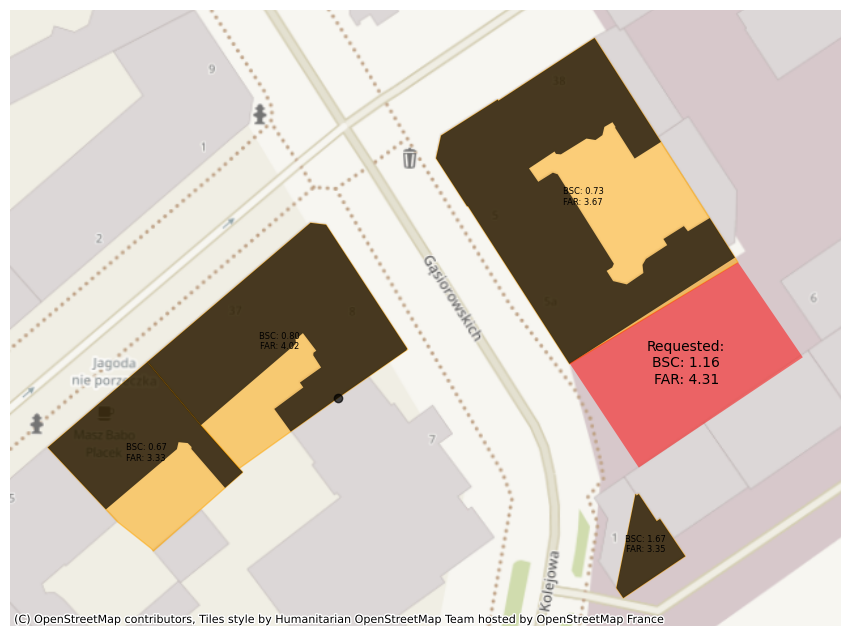

In [77]:
# Visualize
# Base layers
fig, ax = plt.subplots(figsize=(12, 8))
built_up_plots.plot(ax=ax, color='orange', edgecolor='orange', alpha=0.5)
gpd.GeoSeries(plot_road_sides).plot(ax=ax, color='red', linewidth=2)
buildings.clip(built_up_plots.geometry.union_all()).plot(ax=ax, color='black', alpha=0.7)
site.plot(ax=ax, color='red', alpha=0.5)

# Annotate plots with metrics
for _, metrics in plot_metrics_df.iterrows():
    plot = built_up_plots[built_up_plots['ID_DZIALKI'] == metrics['plot_id']]
    plot_geom = plot.geometry
    if not plot_geom.empty:
        centroid = plot_geom.iloc[0].centroid
        if True:
            # Plot setback
            #adjacent_road_neighbors = get_road_neighbors(plot.geometry)
            #adjacent_access_road = get_access_road(plot.geometry, adjacent_road_neighbors)
            #adjacent_road_side = get_road_side(plot.geometry, adjacent_access_road.geometry)
            #setback_road_side = adjacent_road_side.buffer(metrics['setback'])
            #plot_geom.intersection(setback_road_side).plot(ax=ax, color='red', alpha=0.5)
            
            ax.annotate(
                f"BSC: {metrics['building_coverage_ratio']:.2f}\n"
                f"FAR: {metrics['floor_area_ratio']:.2f}\n", 
                xy=(centroid.x, centroid.y),
                xytext=(0, 0), 
                textcoords='offset points',
                ha='center', 
                va='center', 
                color='black',
                fontsize=6
            )
            
        else:
            ax.annotate(
                f"BSC: {metrics['building_coverage_ratio']:.2f}\n"
                f"FAR: {metrics['floor_area_ratio']:.2f}\n"
                f"W: {metrics['front_elevation_width']:.1f}m",
                xy=(centroid.x, centroid.y),
                xytext=(0, 0), 
                textcoords='offset points',
                ha='center', 
                va='center', 
                color='white',
                fontsize=6
            )

site_centroid = site_polygon.centroid
#site_road_side = get_road_side(site_polygon, site_access_road.geometry)
#setback_area = site_polygon.intersection(site_road_side.buffer(zoning_setback))
#gpd.GeoSeries(setback_area).plot(ax=ax, color='red', alpha=0.5)
#ax.annotate(f"{zoning_setback:.1f}m", 
#            xy=(setback_area.centroid.x, setback_area.centroid.y), 
#            ha='center', va='center', color='pink', fontsize=8)
ax.annotate(f"Requested:\nBSC: {zoning_coverage_ratio_max:.2f}\nFAR: {zoning_floor_area_ratio:.2f}", 
            xy=(site_centroid.x, site_centroid.y), 
            ha='center', va='center', color='black', fontsize=10)

ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()


## Input data


In [62]:
# Read GIS data
#roads = gpd.read_file('data/GIS/2261_ulice_egib_wfs_gml.gml')
plots = gpd.read_file('data/GIS/2261_dzialki_egib_wfs_gml.gml')
buildings = gpd.read_file('data/GIS/budynki_2022.gpkg')

# Get our site geometry
site_gml_id = 'dzialki.238458'
site = plots[plots['gml_id'] == site_gml_id]
site.to_crs(epsg=2177)
site_polygon = site.geometry.iloc[0]

DataSourceError: data/GIS/2261_dzialki_egib_wfs_gml.gml: No such file or directory

## Find road access

Site has access from 1 road plot(s): 
Łowców


/var/folders/j5/0qh0dgj5607fhs9231nrxjww0000gn/T/ipykernel_1056/3297165060.py:42: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


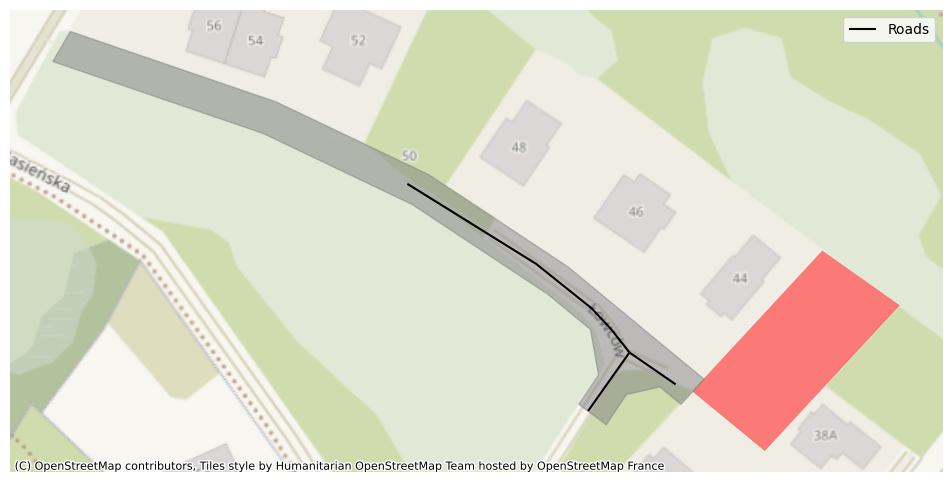

In [486]:
def get_road_neighbors(site_polygon):
    """Get neighboring plots that have significant road access (intersection > 1m)."""
    # Get all neighbors
    neighbors = plots[plots.geometry.touches(site_polygon)]
    
    # Join with roads
    road_neighbors = gpd.sjoin(neighbors, roads, how='inner', predicate='intersects', lsuffix='neighbor', rsuffix='road')
    
    # Filter by intersection length
    min_road_length = 5.0  # minimum 5 meters of road frontage
    valid_neighbors = []
    
    for _, neighbor in road_neighbors.iterrows():
        intersection = neighbor.geometry.intersection(roads[roads['gml_id'] == neighbor['gml_id_road']].geometry.iloc[0])
        if intersection.length >= min_road_length:
            valid_neighbors.append(neighbor)
    
    if not valid_neighbors:
        return gpd.GeoDataFrame(columns=road_neighbors.columns, crs=road_neighbors.crs)
    
    # Create GeoDataFrame from valid neighbors
    valid_road_neighbors = gpd.GeoDataFrame(valid_neighbors, crs=road_neighbors.crs)
    
    # Drop duplicates and apply size filter
    unique_road_neighbors = valid_road_neighbors.drop_duplicates(subset='gml_id_neighbor')
    max_plot_area = 10000
    unique_road_neighbors = unique_road_neighbors[unique_road_neighbors.area <= max_plot_area]
    
    return unique_road_neighbors

#road_neighbors = get_road_neighbors(site_polygon)
#print("Site has access from", road_neighbors.shape[0], "road plot(s): ")
#for idx, road in road_neighbors.iterrows():
#    print(road['nazwa_ulicy'])

fig, ax = plt.subplots(figsize=(16, 6))
site.plot(ax=ax, color='red', alpha=0.5, label='Site')
road_neighbors.plot(ax=ax, color='gray', edgecolor='gray', alpha=0.5, label='Neighbors', legend=True)
roads.clip(road_neighbors.geometry.union_all()).plot(ax=ax, color='black', label='Roads')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.legend()



In [487]:
def get_road_side(plot_geom, road_geom, buffer_distance=0.1):
    """Get the road-facing side of a plot."""
    # Create a small buffer around the road polygon
    road_buffer = road_geom.buffer(buffer_distance)
    
    # Get the plot boundary
    plot_boundary = plot_geom.boundary
    
    # Find the intersection with the road buffer
    road_side = plot_boundary.intersection(road_buffer)
    
    # If we got a MultiLineString, convert it to the longest LineString
    if road_side.geom_type == 'MultiLineString':
        # Get the longest part
        road_side = max(road_side.geoms, key=lambda x: x.length)
    
    # Verify we have a valid road side with non-zero length
    if road_side.is_empty or road_side.length < 0.01:  # Using 1cm as minimum length
        print(f"Warning: Invalid road side found (length={road_side.length:.2f}m)")
        return None
        
    return road_side

def get_access_road(site_geom, road_neighbors):
    """Get the access road of the plot defined as the road plot with the longest common boundary."""
    longest_boundary = 0
    site_access_road = None
    
    for _, road in road_neighbors.iterrows():
        road_side = get_road_side(site_geom, road.geometry)
        if road_side is not None:  # Only process valid road sides
            boundary_length = road_side.length
            if boundary_length > longest_boundary:
                longest_boundary = boundary_length
                site_access_road = road
    
    return site_access_road

#site_access_road = get_access_road(site_polygon, road_neighbors)
#print(site_access_road['nazwa_ulicy'], "is the access road")

site_access_road = None

def get_frontage_length(plot_polygon, site_access_road):
    """Get the frontage length of the site from the access road."""
    site_access_road_side = get_road_side(plot_polygon, site_access_road.geometry)
    return site_access_road_side.length

frontage_length = get_frontage_length(site_polygon, site_access_road)
analysis_radius = max(50, min(3 * frontage_length, 200))

print(f"Site frontage length: {frontage_length:.2f}m")
print(f"Analysis radius based on frontage length: {analysis_radius:.2f}m")


Łowców is the access road
Site frontage length: 4.20m
Analysis radius based on frontage length: 50.00m


/var/folders/j5/0qh0dgj5607fhs9231nrxjww0000gn/T/ipykernel_1056/3437474524.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


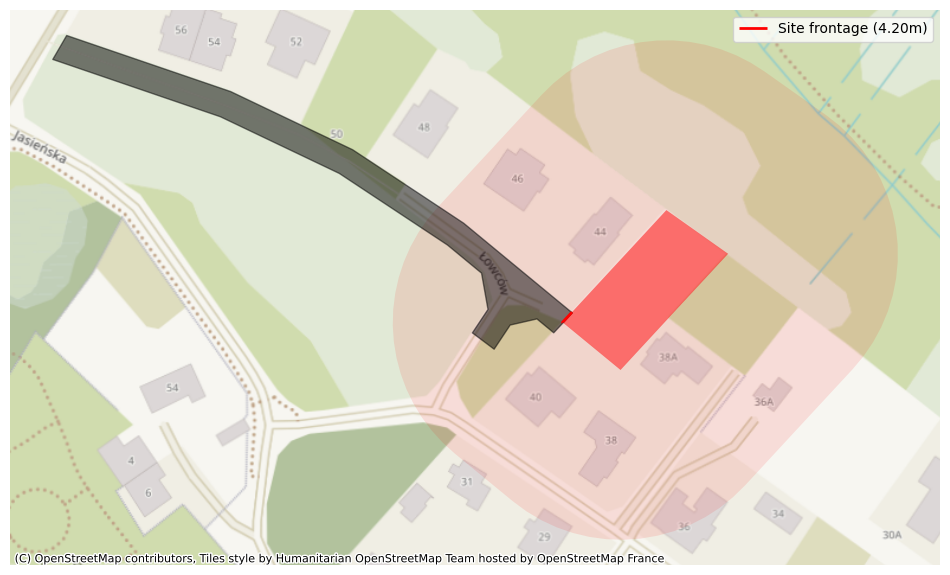

In [488]:
analysis_area = site.buffer(analysis_radius)
road_side = get_road_side(site_polygon, site_access_road.geometry)

fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', alpha=0.5, label='Site')
analysis_area.plot(ax=ax, color='red', alpha=0.1, label='Analysis Area')
gpd.GeoSeries(site_access_road.geometry).plot(ax=ax, color='black', edgecolor='black', alpha=0.5, label='Access Road')
gpd.GeoSeries(road_side).plot(ax=ax, color='red', linewidth=2, label=f'Site frontage ({frontage_length:.2f}m)')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.legend()


## Check if zoning conditions can be issued

Zoning conditions can be issued only if there are built-up plots that are accessed from the same road as the site.

In [489]:
# Check if there are any built-up plots adjacent to the same access road
access_road_neighbors = plots[plots.geometry.touches(site_access_road.geometry)]

# Find built-up neighbors on the same road
buildings['centroid'] = buildings.centroid
building_centroids = buildings.set_geometry('centroid', inplace=False).set_crs(epsg=2177)
built_up_access_road_neighbors = gpd.sjoin(access_road_neighbors, building_centroids, how='inner', predicate='intersects', lsuffix='neighbors', rsuffix='building')

# Drop duplicates
print("There are", built_up_access_road_neighbors['gml_id'].nunique(), "built-up plots on the same access road as the site")

There are 7 built-up plots on the same access road as the site


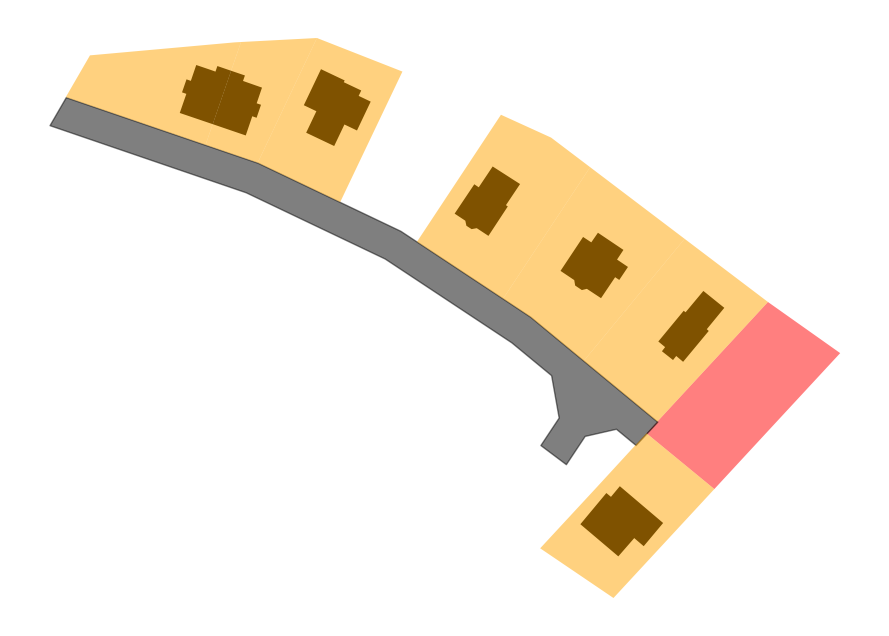

In [490]:
fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', alpha=0.5, label='Site')
gpd.GeoSeries(site_access_road.geometry).plot(ax=ax, color='black', edgecolor='black', alpha=0.5, label='Access Road')
buildings[buildings['GID'].isin(built_up_access_road_neighbors['GID'])].plot(ax=ax, color='black', label='Buildings on Plots')

built_up_access_road_neighbors = built_up_access_road_neighbors.drop_duplicates(subset='gml_id')
built_up_access_road_neighbors.plot(ax=ax, color='orange', alpha=0.5, label='Built-up Neighbors on the Same Access Road')

#ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()

## Existing conditions in the analysis area

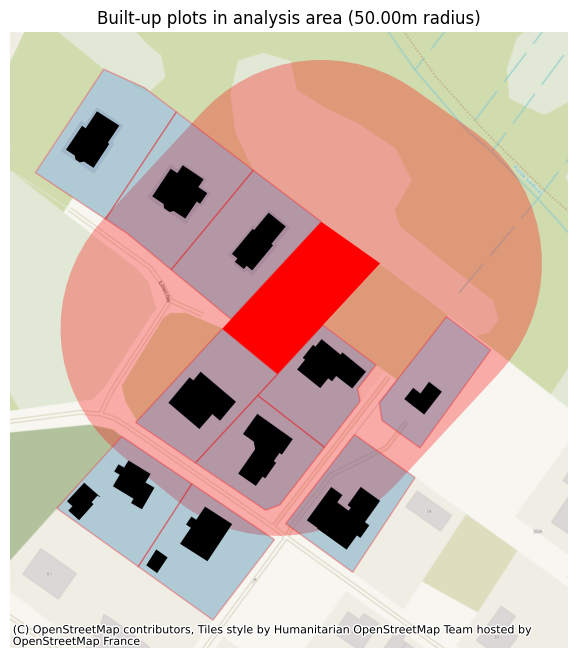

In [491]:
# Find plots in the analysis area
analyzed_plots = plots[plots.geometry.intersects(analysis_area.union_all())]
built_up_plots = gpd.sjoin(analyzed_plots, building_centroids, how='inner', predicate='intersects', lsuffix='plot', rsuffix='building')


# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', label='Site')
gpd.GeoSeries(analysis_area).plot(ax=ax, color='red', alpha=0.3, label='Analysis Area')
built_up_plots.drop_duplicates(subset='gml_id').plot(ax=ax, edgecolor='red', alpha=0.3, label='Analysis Plots')
buildings.clip(built_up_plots.geometry.union_all()).plot(ax=ax, color='black', label='Buildings')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.title(f"Built-up plots in analysis area ({analysis_radius:.2f}m radius)")
plt.show()


In [492]:
from shapely.geometry import Point, LineString

# Methods for calculating plot metrics
def extend_line(line, distance=20):
    """Extend a LineString in both directions."""
    # Get coordinates of the line
    coords = list(line.coords)
    
    # Get the first and last points
    p1 = Point(coords[0])
    p2 = Point(coords[-1])
    
    # Get the vector of the line
    vector = [(p2.x - p1.x), (p2.y - p1.y)]
    
    # Normalize the vector
    length = (vector[0]**2 + vector[1]**2)**0.5
    if length == 0:
        return line
    unit_vector = [v/length for v in vector]
    
    # Create new start and end points
    new_start = (
        p1.x - unit_vector[0] * distance,
        p1.y - unit_vector[1] * distance
    )
    new_end = (
        p2.x + unit_vector[0] * distance,
        p2.y + unit_vector[1] * distance
    )
    
    return LineString([new_start, coords[0], coords[-1], new_end])

def get_building_front_elevation(building_geom, road_side):
    """Get the width of building front by projecting onto road side line."""
    # Handle MultiLineString by getting all coordinates
    if road_side.geom_type == 'MultiLineString':
        # Get all coordinates from all lines
        all_coords = []
        for line in road_side.geoms:
            all_coords.extend(list(line.coords))
        # Create a simplified line using first and last points
        simplified_road_side = LineString([all_coords[0], all_coords[-1]])
    else:
        # If it's already a LineString, just use its endpoints
        coords = list(road_side.coords)
        simplified_road_side = LineString([coords[0], coords[-1]])

    # Extend the road side line to ensure proper projections
    extended_road_side = extend_line(simplified_road_side, distance=100)
    
    # Get all vertices of the building polygon
    vertices = list(building_geom.exterior.coords)
    
    # Project each vertex onto the extended road side and filter out invalid projections
    projections = []
    for vertex in vertices:
        point = Point(vertex)
        proj = extended_road_side.project(point)
        # Only keep projections that are within the original road side length
        if 0 <= proj <= simplified_road_side.length:
            projections.append(proj)
    
    if not projections:  # If no valid projections found
        return LineString()  # Return empty line
        
    # Get the min and max projections to find the extent
    min_proj = min(projections)
    max_proj = max(projections)
    
    # Get the points on the road side
    point_start = simplified_road_side.interpolate(min_proj)
    point_end = simplified_road_side.interpolate(max_proj)
    
    return LineString([point_start, point_end])

In [493]:
def compute_and_visualize_building_projection(building_geom, road_side, ax=None, title=None):
    """Visualize how building vertices project onto the road line."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the building and road
    gpd.GeoSeries(building_geom).plot(ax=ax, color='black', alpha=0.5, label='Building')
    gpd.GeoSeries(road_side).plot(ax=ax, color='red', linewidth=2, label='Road Side')
    
    # Get the simplified road line
    if road_side.geom_type == 'MultiLineString':
        all_coords = []
        for line in road_side.geoms:
            all_coords.extend(list(line.coords))
        simplified_road_side = LineString([all_coords[0], all_coords[-1]])
    else:
        coords = list(road_side.coords)
        simplified_road_side = LineString([coords[0], coords[-1]])
    
    # Plot simplified road line
    gpd.GeoSeries(simplified_road_side).plot(ax=ax, color='blue', linewidth=1, label='Simplified Road')
    
    # Get extended road line
    extended_road_side = extend_line(simplified_road_side, distance=20)
    gpd.GeoSeries(extended_road_side).plot(ax=ax, color='blue', linewidth=1, linestyle=':', label='Extended Road')
    
    # Plot building vertices and their projections
    vertices = list(building_geom.exterior.coords)
    projections = []
    for vertex in vertices:
        point = Point(vertex)
        # Plot vertex
        gpd.GeoSeries(point).plot(ax=ax, color='black', marker='o', markersize=5)
        
        # Project point and plot projection line
        proj = extended_road_side.project(point)
        projections.append(proj)
        proj_point = extended_road_side.interpolate(proj)
        
        # Plot projection line
        projection_line = LineString([point, proj_point])
        gpd.GeoSeries(projection_line).plot(ax=ax, color='gray', linewidth=1, linestyle=':')

    # Get the min and max projections to find the extent
    min_proj = min(projections)
    max_proj = max(projections)
    
    # Get the points on the extended road side (not the simplified one)
    point_start = extended_road_side.interpolate(min_proj)
    point_end = extended_road_side.interpolate(max_proj)
    
    # Plot the front elevation line
    front_elevation = LineString([point_start, point_end])
    gpd.GeoSeries(front_elevation).plot(ax=ax, color='green', linewidth=3, label=f'Front elevation width')
    
    if title:
        ax.set_title(title)
    return front_elevation, ax



Plot dzialki.314477
Plot area: 847 m2
Plot buildings: 1
Building coverage ratio: 0.2265195517282196
Floor area ratio: 0.4530391034564392
Plot has 3 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.87699
Plot area: 705 m2
Plot buildings: 1
Building coverage ratio: 0.24364970165566663
Floor area ratio: 0.48729940331133326
Plot has 1 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.87399
Plot area: 860 m2
Plot buildings: 2
Building coverage ratio: 0.1891859128868079
Floor area ratio: 0.43402589597808744
Plot has 2 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.87399
Plot area: 860 m2
Plot buildings: 2
Building coverage ratio: 0.1891859128868079
Floor area ratio: 0.43402589597808744
Plot has 2 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.252770
Plot area: 846 m2
Plot buildings: 1
Building coverage ratio: 0.27165729421943136
Floor area ratio: 0.5433145884388627
Plot has 4 road neighbors: ['Włóczników' 'Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.315501
Plot area: 1095 m2
Plot buildings: 1
Building coverage ratio: 0.14394212409841325
Floor area ratio: 0.2878842481968265
Plot has 1 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.315502
Plot area: 1033 m2
Plot buildings: 1
Building coverage ratio: 0.13976797588627973
Floor area ratio: 0.27953595177255947
Plot has 1 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.253826
Plot area: 913 m2
Plot buildings: 2
Building coverage ratio: 0.18297520791036564
Floor area ratio: 0.18297520791036564
Plot has 3 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.253826
Plot area: 913 m2
Plot buildings: 2
Building coverage ratio: 0.18297520791036564
Floor area ratio: 0.18297520791036564
Plot has 3 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.87164
Plot area: 740 m2
Plot buildings: 1
Building coverage ratio: 0.24332186176022988
Floor area ratio: 0.24332186176022988
Plot has 2 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.361122
Plot area: 660 m2
Plot buildings: 1
Building coverage ratio: 0.08488631992526616
Floor area ratio: 0.08488631992526616
Plot has 2 road neighbors: ['Włóczników' 'Łowców']
Plot access road: Włóczników


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)



Plot dzialki.315500
Plot area: 1016 m2
Plot buildings: 1
Building coverage ratio: 0.13138771882372338
Floor area ratio: 0.26277543764744676
Plot has 1 road neighbors: ['Łowców']
Plot access road: Łowców


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


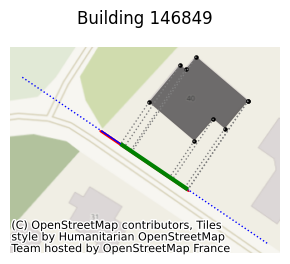

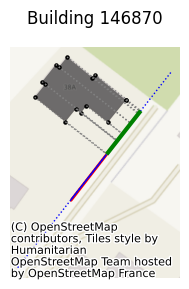

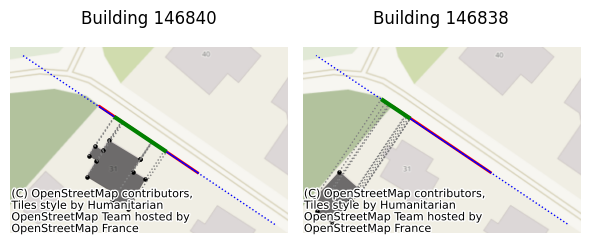

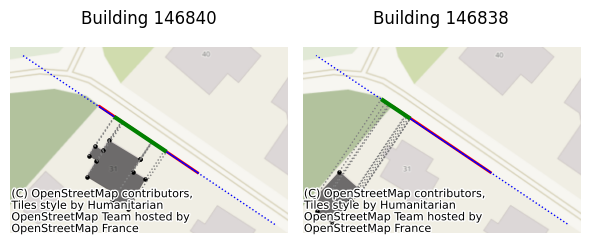

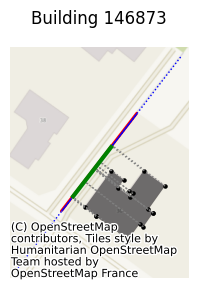

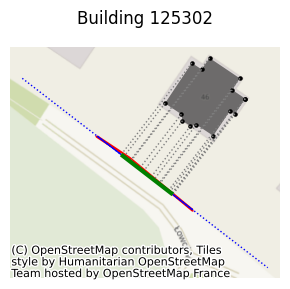

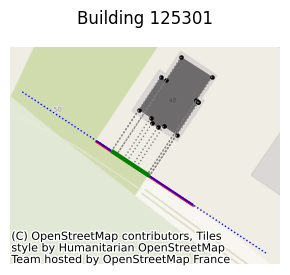

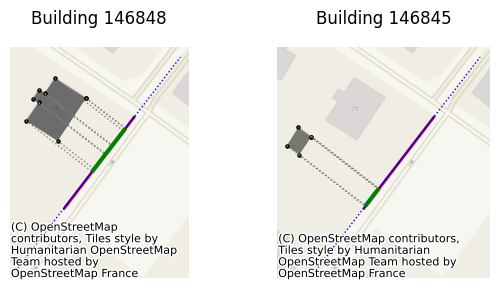

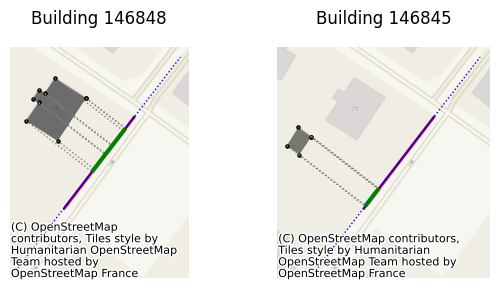

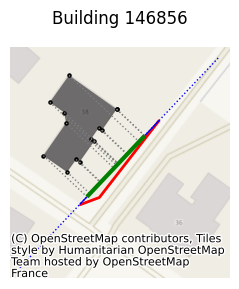

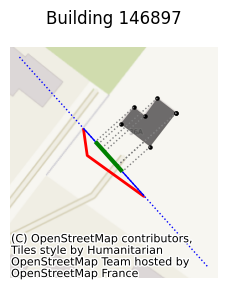

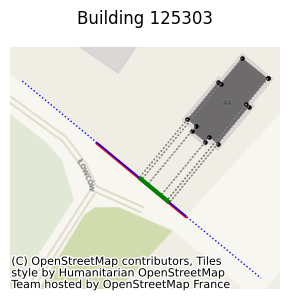

In [494]:
plot_road_sides = []
access_roads = []
front_elevations = []
plot_metrics = []

for _, plot in built_up_plots.iterrows():
    print("\nPlot", plot['gml_id'])
    
    plot_area = plot.geometry.area
    print(f"Plot area: {plot_area:.0f} m2")

    plot_buildings = buildings[buildings['GID'].isin(
        built_up_plots[
            built_up_plots['gml_id'] == plot['gml_id']
        ]['GID']
    )]
    print("Plot buildings:", plot_buildings.shape[0])

    # Building coverage ratio
    bcr = plot_buildings.geometry.area.sum() / plot_area
    print("Building coverage ratio:", bcr)

    # Floor area ratio
    building_footprint = plot_buildings.geometry.area
    floors = plot_buildings['LICZBA_KONDYGNACJI']
    gross_floor_area = building_footprint * floors
    total_gross_floor_area = gross_floor_area.sum()
    far = total_gross_floor_area / plot_area
    print("Floor area ratio:", far)

    # Front width
    plot_road_neighbors = get_road_neighbors(plot.geometry)
    print("Plot has", plot_road_neighbors.shape[0], "road neighbors:", plot_road_neighbors['nazwa_ulicy'].unique())
    if plot_road_neighbors.shape[0] == 0:
        print("Plot has no road neighbors, skipping")
        continue
    plot_access_road = get_access_road(plot.geometry, plot_road_neighbors)
    print("Plot access road:", plot_access_road['nazwa_ulicy'] if plot_access_road is not None else "None")

    plot_road_side = get_road_side(plot.geometry, plot_access_road.geometry)
    access_roads.append(plot_access_road)
    plot_road_sides.append(plot_road_side)
    
    # Create subplots based on number of buildings
    n_buildings = len(plot_buildings)
    fig, axes = plt.subplots(1, n_buildings, figsize=(3 * n_buildings, 3))
    if n_buildings == 1:
        axes = [axes]  # Make it iterable for single building case

    # Process each building
    plot_front_elevations = []
    for idx, (_, building) in enumerate(plot_buildings.iterrows()):
        building_processed = gpd.GeoSeries(building.geometry).union_all()
        front_elevation, ax = compute_and_visualize_building_projection(
            building_processed, 
            plot_road_side, 
            ax=axes[idx],
            title=f"Building {building['GID']}"
        )
        ctx.add_basemap(axes[idx], crs=2177)
        axes[idx].set_axis_off()

        plot_front_elevations.append(front_elevation)
    

    plt.tight_layout()

    # Add the longest front elevation for the plot
    if plot_front_elevations:
        longest_elevation = max(plot_front_elevations, key=lambda x: x.length)
        front_elevations.append(longest_elevation)
    
    # Check if plot is adjacent to the site and on the same access road
    adjacent = plot.geometry.touches(site_polygon) and plot.geometry.touches(access_road.geometry)
    if adjacent:
        # Compute additional metrics
        building_height = plot_buildings['WYSOKOSC'].max()

        # Setback
        road_side = get_road_side(plot.geometry, plot_access_road.geometry)
        setback = plot_buildings.geometry.distance(road_side).min()

    else:
        building_height = None
        setback = None
    
    plot_metrics.append({
        'plot_id': plot['gml_id'],
        'building_coverage_ratio': bcr,
        'floor_area_ratio': far,
        'front_elevation_width': longest_elevation.length,
        'adjacent': adjacent,
        'building_height': building_height,
        'setback': setback
    })

# Convert to DataFrame for analysis
plot_metrics_df = pd.DataFrame(plot_metrics)
    

In [495]:
plot_metrics_df = plot_metrics_df.drop_duplicates(subset='plot_id')
plot_metrics_df

,plot_id,building_coverage_ratio,floor_area_ratio,front_elevation_width,adjacent,building_height,setback
0,dzialki.314477,0.226520,0.453039,17.066555,True,7.2,9.358722
1,dzialki.87699,0.243650,0.487299,12.874675,False,NaN,NaN
2,dzialki.87399,0.189186,0.434026,13.717664,False,NaN,NaN
4,dzialki.252770,0.271657,0.543315,18.610728,False,NaN,NaN
5,dzialki.315501,0.143942,0.287884,13.822005,False,NaN,NaN
6,dzialki.315502,0.139768,0.279536,10.187223,False,NaN,NaN
7,dzialki.253826,0.182975,0.182975,14.626680,False,NaN,NaN
9,dzialki.87164,0.243322,0.243322,19.316378,False,NaN,NaN
10,dzialki.361122,0.084886,0.084886,8.374216,False,NaN,NaN
11,dzialki.315500,0.131388,0.262775,8.099190,True,7.2,14.410218


In [503]:
# Zoning conditions coverage ratio from min to mean+20%
zoning_coverage_ratio_min = float(plot_metrics_df['building_coverage_ratio'].min())
zoning_coverage_ratio_max = float(plot_metrics_df['building_coverage_ratio'].mean() * 1.2)
zoning_floor_area_ratio = float(plot_metrics_df['floor_area_ratio'].mean() * 1.2)
zoning_height = plot_metrics_df['building_height'].mean()
zoning_front_width = float(plot_metrics_df['front_elevation_width'].mean() * 1.2)
zoning_setback = float(plot_metrics_df['setback'].max())


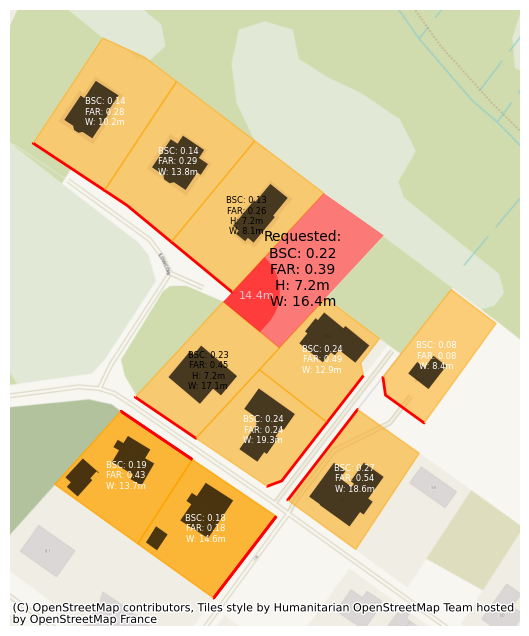

In [504]:
# Visualize
# Base layers
fig, ax = plt.subplots(figsize=(12, 8))
built_up_plots.plot(ax=ax, color='orange', edgecolor='orange', alpha=0.5)
gpd.GeoSeries(plot_road_sides).plot(ax=ax, color='red', linewidth=2)
buildings.clip(built_up_plots.geometry.union_all()).plot(ax=ax, color='black', alpha=0.7)
site.plot(ax=ax, color='red', alpha=0.5)

# Annotate plots with metrics
for _, metrics in plot_metrics_df.iterrows():
    plot = built_up_plots[built_up_plots['gml_id'] == metrics['plot_id']]
    plot_geom = plot.geometry
    if not plot_geom.empty:
        centroid = plot_geom.iloc[0].centroid
        if metrics['adjacent']:
            # Plot setback
            #adjacent_road_neighbors = get_road_neighbors(plot.geometry)
            #adjacent_access_road = get_access_road(plot.geometry, adjacent_road_neighbors)
            #adjacent_road_side = get_road_side(plot.geometry, adjacent_access_road.geometry)
            #setback_road_side = adjacent_road_side.buffer(metrics['setback'])
            #plot_geom.intersection(setback_road_side).plot(ax=ax, color='red', alpha=0.5)
            
            ax.annotate(
                f"BSC: {metrics['building_coverage_ratio']:.2f}\n"
                f"FAR: {metrics['floor_area_ratio']:.2f}\n"
                f"H: {metrics['building_height']:.1f}m\n"
                f"W: {metrics['front_elevation_width']:.1f}m", 
                xy=(centroid.x, centroid.y),
                xytext=(0, 0), 
                textcoords='offset points',
                ha='center', 
                va='center', 
                color='black',
                fontsize=6
            )
            
        else:
            ax.annotate(
                f"BSC: {metrics['building_coverage_ratio']:.2f}\n"
                f"FAR: {metrics['floor_area_ratio']:.2f}\n"
                f"W: {metrics['front_elevation_width']:.1f}m",
                xy=(centroid.x, centroid.y),
                xytext=(0, 0), 
                textcoords='offset points',
                ha='center', 
                va='center', 
                color='white',
                fontsize=6
            )

site_centroid = site_polygon.centroid
site_road_side = get_road_side(site_polygon, site_access_road.geometry)
setback_area = site_polygon.intersection(site_road_side.buffer(zoning_setback))
gpd.GeoSeries(setback_area).plot(ax=ax, color='red', alpha=0.5)
ax.annotate(f"{zoning_setback:.1f}m", 
            xy=(setback_area.centroid.x, setback_area.centroid.y), 
            ha='center', va='center', color='pink', fontsize=8)
ax.annotate(f"Requested:\nBSC: {zoning_coverage_ratio_max:.2f}\nFAR: {zoning_floor_area_ratio:.2f}\nH: {zoning_height:.1f}m\nW: {zoning_front_width:.1f}m", 
            xy=(site_centroid.x, site_centroid.y), 
            ha='center', va='center', color='black', fontsize=10)

ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
